In [1]:
"""Temporary fix for importing modules from parent directory"""

import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from varitop.misc import euler_rule, skew_quaternion, qconj, q2rm, quat_prod
from varitop.integrator import DelIntegrator as DI
from varitop.model import DarliModel

from matplotlib import pyplot as plt
from tqdm import tqdm
import casadi as cs
import numpy as np

In [3]:
urdf_path = "../assets/urdf/skydio_x2.urdf"

In [4]:
linear_0 = np.array([0, 0, 0])
angular_0 = np.array([0, 0, 0, 1])
q_0 = np.concatenate((linear_0, angular_0))

In [5]:
K = cs.vcat(
    [
        cs.hcat([-0.18, 0.18, 0.18, -0.18]),
        cs.hcat([0.14, 0.14, -0.14, -0.14]),
        cs.hcat([-0.0201, 0.0201, 0.0201, -0.0201]),
    ]
)

t0, tf, steps = 0.0, 3.0, 200
dt = (tf - t0) / steps

In [6]:
di = DI()
di.free_body = True
di.model = DarliModel(urdf_path)
di.lagrangian

Function(L:(q[7],dq[7])->(L) SXFunction)

In [7]:
q = cs.SX.sym("q", di.nq)
dq = cs.SX.sym("dq", di.nq)
u = cs.SX.sym("u", di.nu)

In [8]:
# Constraint on unit quaternion
phi0 = cs.Function("phi0", [q], [q[3:].T @ q[3:] - 1])
# force
f = cs.Function(
    "f",
    [q, dq, u],
    [cs.vcat([0, 0, 0, 2 * quat_prod(q[3:], cs.vertcat(K @ u[2:], 0))])],
)

In [9]:
di.add_generalized_forces([f])
di.add_dynamics_constraints([phi0])
di.rule = euler_rule

In [26]:
# Constant input
us = np.full((steps, 6), np.array([0, 0, 0.00, 0.00, 0.0005, 0.0005]))

In [27]:
qs_sol = np.zeros((steps, 7))
qs_sol[0] = q_0
qs_sol[1] = q_0

for i in tqdm(range(2, steps)):
    q0 = qs_sol[i - 2]
    q1 = qs_sol[i - 1]

    qs_sol[i] = di.step(q0, q1, dt, us[i])

100%|██████████| 198/198 [00:00<00:00, 445.96it/s]


In [28]:
basis_vectors = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
rms = q2rm(qs_sol[:, 3:])

In [29]:
# Quaternion angular velocity
def w(q, dq):
    return 2 * quat_prod(qconj(q), dq)

In [30]:
ws_sol = np.zeros((steps, 4))
ws_sol[0] = np.zeros(4)
for i in range(1, len(ws_sol)):
    dqs_i = (qs_sol[i] - qs_sol[i - 1]) / dt
    ws_sol[i] = np.array(w(qs_sol[i, 3:], dqs_i[3:])).ravel()

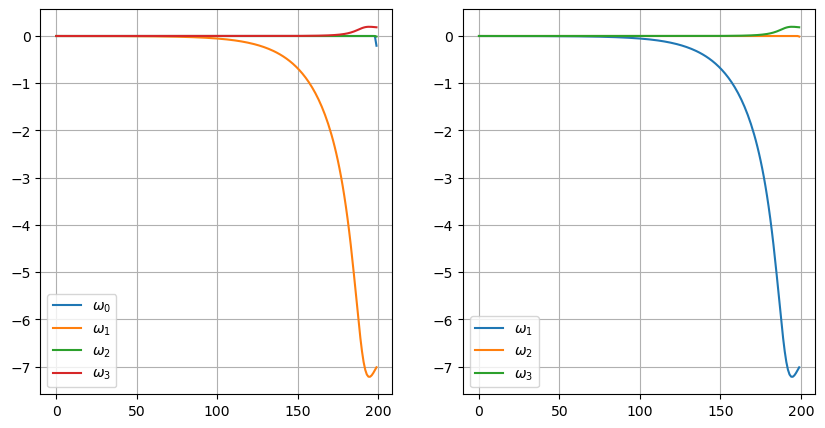

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(ws_sol[:, 0], label="$\omega_0$")
ax[0].plot(ws_sol[:, 1], label="$\omega_1$")
ax[0].plot(ws_sol[:, 2], label="$\omega_2$")
ax[0].plot(ws_sol[:, 3], label="$\omega_3$")

ax[1].plot(ws_sol[:, 1], label="$\omega_1$")
ax[1].plot(ws_sol[:, 2], label="$\omega_2$")
ax[1].plot(ws_sol[:, 3], label="$\omega_3$")

ax[0].grid()
ax[0].legend()
ax[1].grid()
ax[1].legend()
plt.show()

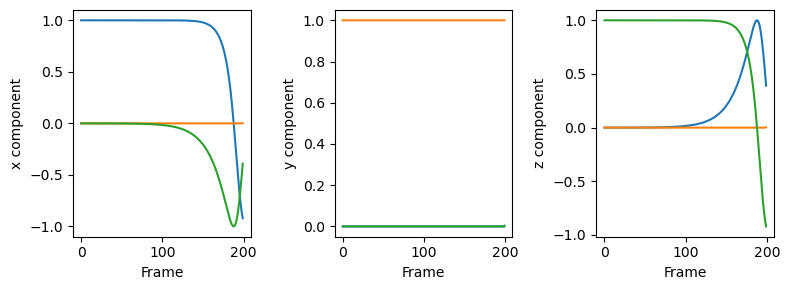

In [32]:
import matplotlib.pyplot as plt

# Extract the x, y, z components of the basis vectors
x = rms[:, 0]
y = rms[:, 1]
z = rms[:, 2]

# Create three separate plots for x, y, z components
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3))

# Plot x component
ax1.plot(x)
ax1.set_xlabel("Frame")
ax1.set_ylabel("x component")

# Plot y component
ax2.plot(y)
ax2.set_xlabel("Frame")
ax2.set_ylabel("y component")

# Plot z component
ax3.plot(z)
ax3.set_xlabel("Frame")
ax3.set_ylabel("z component")

# Display the plots
plt.tight_layout()
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


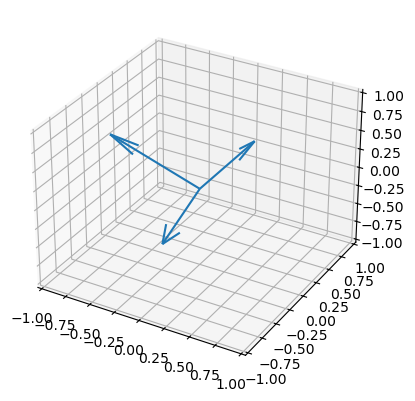

In [33]:
from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

basis = ax.quiver(0, 0, 0, basis_vectors[0], basis_vectors[1], basis_vectors[2])


def update(frame):
    # Rotate the basis vectors
    rotated_vectors = rms[frame] @ basis_vectors.T

    global basis
    basis.remove()
    basis = ax.quiver(
        0, 0, 0, rotated_vectors[0], rotated_vectors[1], rotated_vectors[2]
    )


# Create the animation
animation = FuncAnimation(fig, update, frames=len(qs_sol), interval=tf * 1000 / steps)

# Save the animation as a GIF using Pillow writer
animation.save("evolution_history_x2.gif")

# Display the animation
plt.show()